### Modules used in this notebook
pypsa, plotnine
The notebook also requires a solver (e.g. `Cbc` or GLPK)

# E.003 Extending this model to include two countries
In this notebook you will create a simple power system model simulating a system with two regions connected together with specific month of the year using wind based on atmospheric reanalysis data. The model will be optimised to define the optimal capacity of batteries needed to balance the system.

The used model is PyPSA: [an open-source power system model](https://pypsa.org/)

# Step 02: Load wind, demand data
We use a set of Parquet files containing the electricity demand, wind and solar profiles based on [this dataset](https://researchdata.reading.ac.uk/272/) developed by Bloomfield et al., University of Reading.

The Parquet files provide a data frame with the hourly values for all the European countries for the years 2000-2019 (the original dataset goes back to 1979 but we have kept only the last 20 years to reduce the amount of storage needed to run this notebook).

In [1]:
import pandas as pd
dem = pd.read_parquet('../data/ERA5_full_demand_all_countries_2000_2019_hourly.parquet')
win = pd.read_parquet('../data/ERA5_wind_power_capacity_factor_all_countries_2000_2019_inclusive.parquet')
dem.head()

,datetime,Austria,Belgium,Bulgaria,Croatia,Czech_Republic,Denmark,Finland,France,Germany,...,Norway,Poland,Portugal,Romania,Slovakia,Slovenia,Spain,Sweden,Switzerland,United_Kingdom
0,2000-01-01 00:00:00+00:00,6.149653,8.547436,4.288882,1.557109,6.583412,2.543370,10.218680,56.496736,40.287049,...,15.602364,15.173096,5.161892,6.074548,3.032983,1.177564,23.342019,16.258756,6.420162,31.481235
1,2000-01-01 01:00:00+00:00,6.005393,8.184474,4.241575,1.474065,6.535270,2.489337,10.133998,55.007324,39.336272,...,15.424182,14.849854,4.776771,6.029861,2.986461,1.152904,22.036881,16.147893,6.465112,29.741144
2,2000-01-01 02:00:00+00:00,5.854461,7.972377,4.265739,1.445917,6.463566,2.492441,10.185449,52.251049,39.381310,...,15.410204,14.818497,4.538195,6.085059,2.987110,1.149503,21.423310,16.162053,6.489145,27.999955
3,2000-01-01 03:00:00+00:00,5.945950,7.954598,4.407904,1.465845,6.551649,2.553254,10.472526,51.265385,40.223583,...,15.522155,15.023909,4.418843,6.265306,3.048357,1.170514,21.222722,16.324404,6.523057,27.066848
4,2000-01-01 04:00:00+00:00,6.444086,8.264821,4.780009,1.587208,6.891379,2.748628,11.128114,53.134412,42.170035,...,15.911743,15.634865,4.369596,6.687905,3.175566,1.260816,21.653859,16.956360,6.423579,26.070716


# Step 03: selecting year, month, and the two countries
In this example we simulate a power system model consisting of two regions, each one with a wind power farm and a lithium-ion battery, connected together with an interconnector. We specify the electricity demand and the RES profiles (capacity factors) for a specific month.

In [2]:
selected_year = 2012 # 2000-2019
selected_month = 2 # 1 = January, 12 = December
country01 = 'Spain'
country02 = 'Denmark'

In [3]:
# Select demand  and wind profiles
selected_dem_01 = dem.loc[(pd.DatetimeIndex(dem['datetime']).year == selected_year) & (pd.DatetimeIndex(dem['datetime']).month == selected_month)][country01]
selected_win_01 = win.loc[(pd.DatetimeIndex(win['datetime']).year == selected_year) & (pd.DatetimeIndex(win['datetime']).month == selected_month)][country01]

selected_dem_02 = dem.loc[(pd.DatetimeIndex(dem['datetime']).year == selected_year) & (pd.DatetimeIndex(dem['datetime']).month == selected_month)][country02]
selected_win_02 = win.loc[(pd.DatetimeIndex(win['datetime']).year == selected_year) & (pd.DatetimeIndex(win['datetime']).month == selected_month)][country02]

# Step 04: Building the power system model
We create here a single-bus PyPSA network with:
  - `Wind`: A wind generator with the cost of 100 000 EUR per MW
  - `Battery`: a battery with 3 hours of storage with the cost of 30 000 EUR per MW. The efficiency is 90%.

The system has an electricity demand defined by the load `L1`

In [4]:
import pypsa, logging
pypsa.pf.logger.setLevel(logging.WARNING)

network = pypsa.Network(snapshots = selected_dem_01.index)
network.add("Bus", "B1")
network.add("Bus", "B2")

network.add("Generator", "Wind01",
            bus="B1",
            capital_cost = 100_000,
            p_max_pu = selected_win_01,
            p_nom_extendable = True,
            control="PQ")

network.add("Generator", "Wind02",
            bus="B2",
            capital_cost = 100_000,
            p_max_pu = selected_win_02,
            p_nom_extendable = True,
            control="PQ")


network.add("StorageUnit", "Battery01",
            bus="B1",
            capital_cost = 30_000,
            efficiency_store = 0.9,
            efficiency_dispatch = 0.9,
            max_hours = 3,
            p_nom_extendable = True
            )

network.add("StorageUnit", "Battery02",
            bus="B2",
            capital_cost = 30_000,
            efficiency_store = 0.9,
            efficiency_dispatch = 0.9,
            max_hours = 3,
            p_nom_extendable = True
            )

network.add('Link', 'ITC01-02',
            bus0 = 'B1',
            bus1 = 'B2',
            p_min_pu = -1,
            marginal_cost = 0.1,
            p_nom = 8000 )

network.add("Load", "L1",
            bus="B1",
            p_set=selected_dem_01*1e3)
network.add("Load", "L2",
            bus="B2",
            p_set=selected_dem_02*1e3)


# Step 05: Running the model
Here we solve the linear optimal power flow defined in the PyPSA network created in the step before. We print the optimal capacities (in MW) of wind, solar and batteries found by the solver.

In [5]:
network.optimize(solver_name = 'glpk')

Index(['ITC01-02'], dtype='object', name='Link')
Index(['B1', 'B2'], dtype='object', name='Bus')
Index(['ITC01-02'], dtype='object', name='Link')
Index(['B1', 'B2'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Glpk solver
INFO:linopy.io: Writing time: 0.12s
INFO:linopy.solvers:GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\matte\AppData\Local\Temp\linopy-problem-ediy3cmr.lp --output
 C:\Users\matte\AppData\Local\Temp\linopy-solve-l94u1rv8.sol
Reading problem data from 'C:\Users\matte\AppData\Local\Temp\linopy-problem-ediy3cmr.lp'...
15316 rows, 6268 columns, 29234 non-zeros
82149 lines were read
GLPK Simplex Optimizer 5.0
15316 rows, 6268 columns, 29234 non-zeros
Preprocessing...
8352 rows, 6268 columns, 22270 non-zeros
Scaling...
 A: min|aij| =  3.549e-03  max|aij| =  3.000e+00  ratio =  8.454e+02
GM: min|aij| =  5.035e-01  max|aij| =  1.986e+00  ratio =  3.945e+00
EQ: min|aij| =  2.564e-01  max|aij| =  1.000e+00  ratio

('ok', 'optimal')

In [6]:
network.statistics.expanded_capacity()

component    carrier
Link         AC              0.00
StorageUnit  -          287904.95
Generator    -          199359.60
dtype: float64

# Step 06: Plotting the dispatching
To plot the generation of the three assets modeled in this example we need to insert the data contained in the `network` object into a Pandas data frame. This is eventually used for a plot made with [plotnine](https://plotnine.readthedocs.io/en/stable/)

In [7]:
gen_list = network.generators[['bus']].reset_index()
gen_list['type'] = gen_list['Generator'].str.split('_', expand = True).iloc[:,0]
gen = (pd.merge(
    network.generators_t.p
    .unstack()
    .reset_index(), gen_list)
       .groupby(['type', 'bus', 'snapshot'])
       .sum()
       .reset_index()
      ).rename(columns = {0: 'prod'})

sto_list = network.storage_units[['bus']].reset_index()
sto_list['type'] = sto_list['StorageUnit'].str.split('_', expand = True).iloc[:,0]
sto = (pd.merge(
    network.storage_units_t.p
    .unstack()
    .reset_index(), sto_list)
       .groupby(['type', 'bus', 'snapshot'])
       .sum().reset_index()
      ).rename(columns = {0: 'prod'})

df = pd.concat([gen, sto])
df.head()

,type,bus,snapshot,Generator,prod,StorageUnit
0,Wind01,B1,105936,Wind01,39912.8,NaN
1,Wind01,B1,105937,Wind01,35276.9,NaN
2,Wind01,B1,105938,Wind01,24127.2,NaN
3,Wind01,B1,105939,Wind01,23191.0,NaN
4,Wind01,B1,105940,Wind01,23630.7,NaN


INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


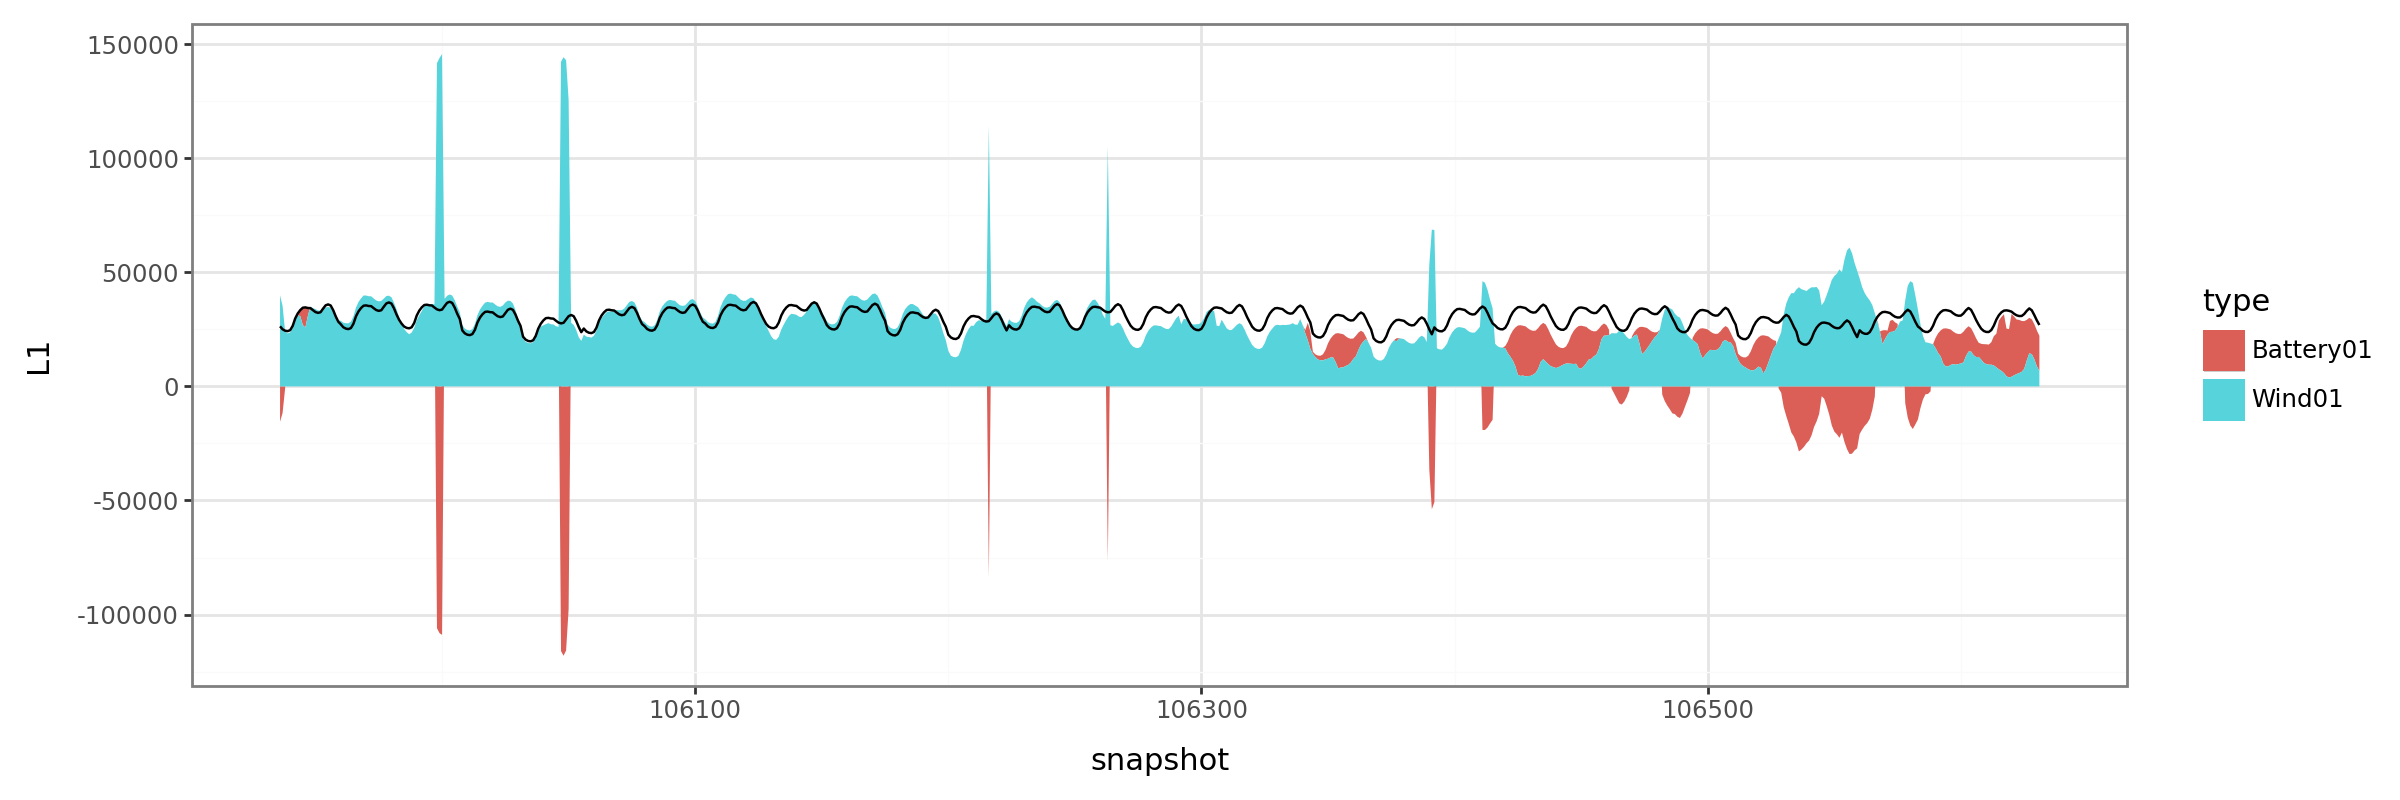

In [8]:
import plotnine
plotnine.options.figure_size = (12, 4)
# First country
(
    plotnine.ggplot(pd.DataFrame(network.loads_t.p_set.L1).reset_index(), plotnine.aes(x='snapshot', y='L1')) +
    plotnine.geom_area(plotnine.aes(x = 'snapshot', y = 'prod', fill = 'type'), data= df.query("bus == 'B1'")) +
    plotnine.theme_bw() +
    plotnine.geom_line()
)


INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


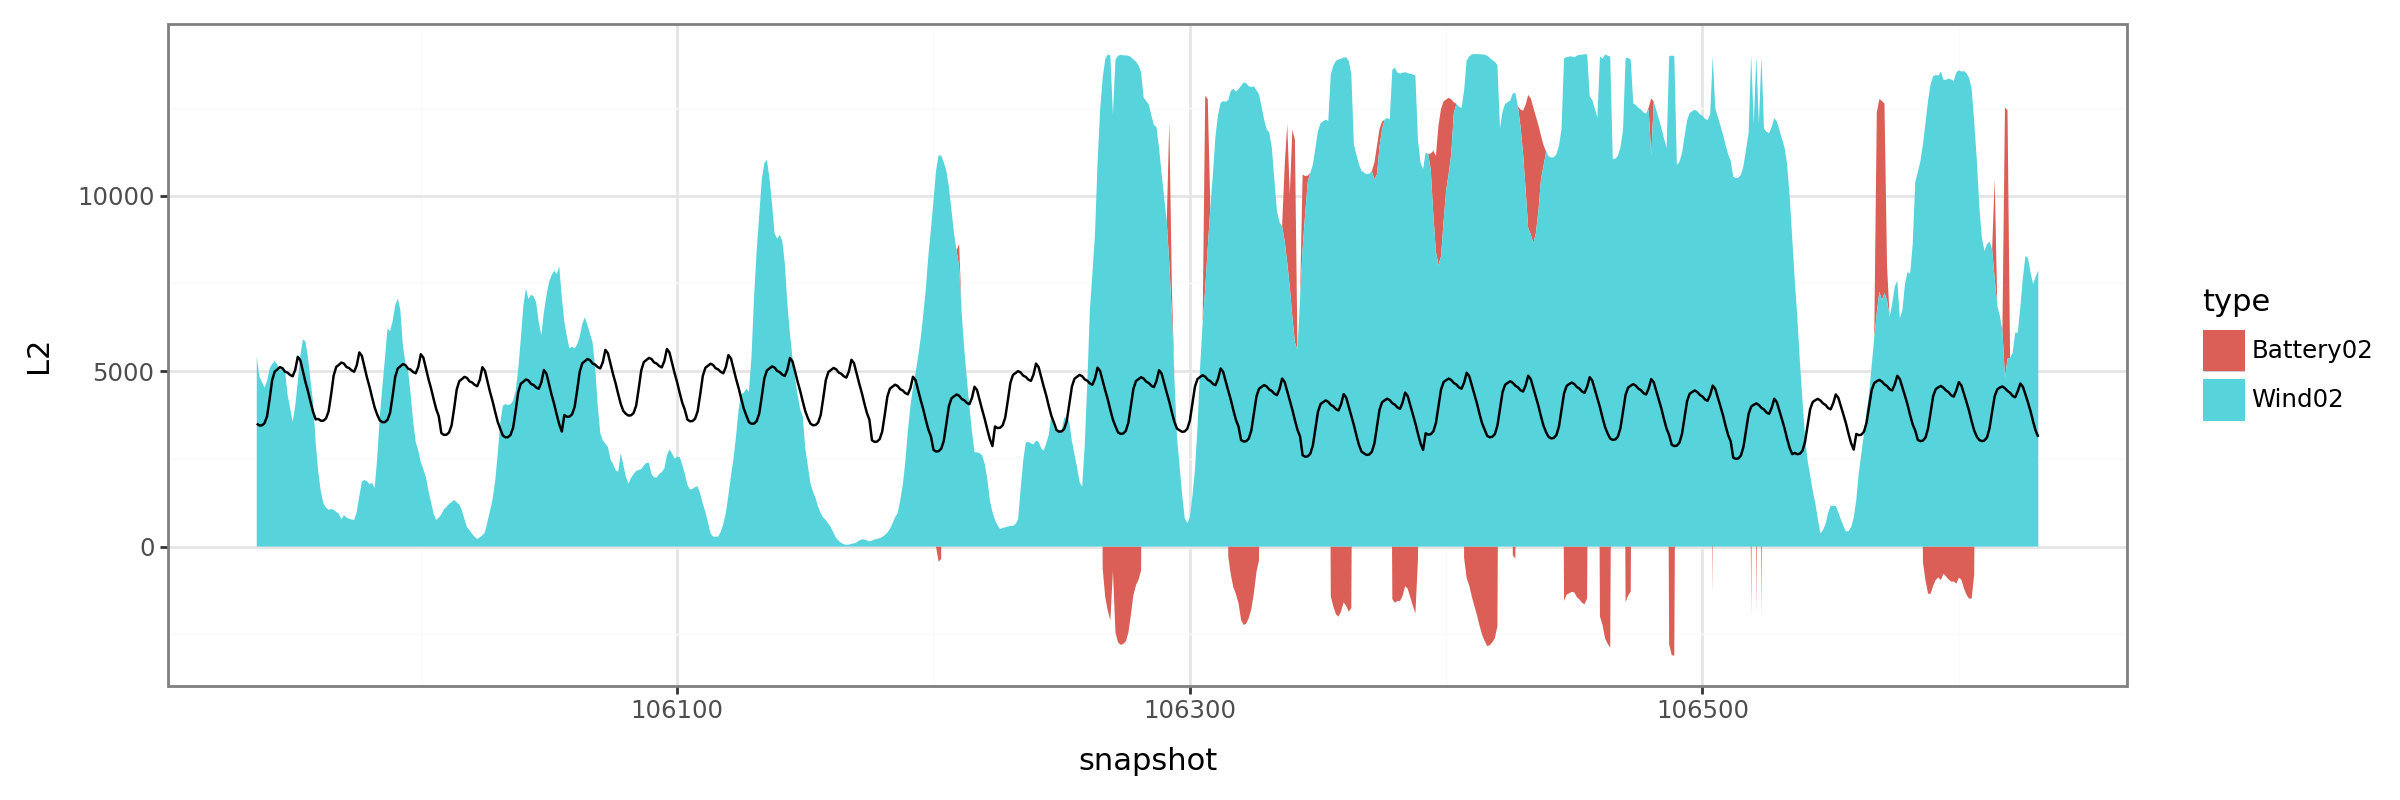

In [9]:
# Second country
(
    plotnine.ggplot(pd.DataFrame(network.loads_t.p_set.L2).reset_index(), plotnine.aes(x='snapshot', y='L2')) +
    plotnine.geom_area(plotnine.aes(x = 'snapshot', y = 'prod', fill = 'type'), data= df.query("bus == 'B2'")) +
    plotnine.theme_bw() +
    plotnine.geom_line()
)

In [ ]:
# ITC
(
    plotnine.ggplot(pd.DataFrame(network.links_t.p0).reset_index(), plotnine.aes(x='snapshot', y='ITC01-02')) +
    plotnine.geom_hline(yintercept=0, linetype = 'dashed') +
    plotnine.geom_line() +
    plotnine.theme_bw()
)
